In [ ]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
# from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import Transformer
from torch.utils.data import dataset

# Data loading

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, random_split,DataLoader

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class QnADataset(Dataset):
  def yield_tokens(self, df):
    for index, row in df.iterrows():
      # print(row)
      input = self.tokenizer(row['subpara'])
      output = ['[start]']
      output.extend(self.tokenizer(row['Question']))
      output.append('[sep]')
      output.extend(self.tokenizer(row['Answer']))
      output.append('[end]')
      yield input, output

  def yield_tokens_onebyone(self, df):
    for input, output in self.yield_tokens(df):
      yield input
      yield output

  def toPaddedTensor(self, lst, pad_to_sz):
      c_ids = torch.full((1,pad_to_sz),fill_value=self.vocab['[pad]'], dtype=torch.long)
      c_ids[0, :len(lst[:pad_to_sz])] = torch.tensor(lst[:pad_to_sz])
      return c_ids


  def data_process(self, df):
    input_arr = []
    output_arr = []
    self.input_lengths = []
    self.output_lengths = []

    for input, output in self.yield_tokens(df):
      self.input_lengths.append(len(input))
      self.output_lengths.append(len(output))

      input_arr.append(self.toPaddedTensor(self.vocab(input),args['max_c_len']))
      if len(output) > args['max_qna_len']:
        raise OverflowError(f"Received QnA with length {len(output)}, which is more than the max limit of {args['max_qna_len']}.\nRaise args['max_qna_len'] and retry.")
      output_arr.append(self.toPaddedTensor(self.vocab(output),args['max_qna_len']))


    input_T = torch.cat(input_arr)
    output_T = torch.cat(output_arr)
    return input_T, output_T

  def __init__(self, fname, args):
    self.args = args
    self.data = pd.read_csv(fname, header=0,dtype={'Paragraph':'string','subpara':'string'}).reset_index()
    self.data = self.data[['subpara','Question','Answer']].dropna()
    self.tokenizer = get_tokenizer('basic_english')
    self.vocab = build_vocab_from_iterator(self.yield_tokens_onebyone(self.data),special_first=True, specials=['<unk>','[pad]','[start]','[sep]', '[end]'])

    self.vocab.set_default_index(self.vocab['<unk>'])
    self.input, self.output = self.data_process(self.data)

  def __len__(self):
    # return 10
    return len(self.data.index)

  def __getitem__(self, idx):
    return self.input[idx,:], self.output[idx,:]

In [ ]:
fname = 'processed3_renewables_f1000_11_07_2023 with db description.csv'
args = {
    "max_c_len": 300,
    "max_qna_len": 180
}
full_dataset = QnADataset(fname, args)
full_dataset.data.head()

,subpara,Question,Answer
0,Trend in allocation of total NIH budget to NIH...,What percentage of the Total NIH Budget is all...,The percentage of the Total NIH Budget allocat...
1,Total NIH spending on R01-equivalent grants (i...,How much of the Total NIH Budget was allocated...,The percentage of the Total NIH Budget allocat...
2,The full post-doubling era (FY2003–2008) does ...,What is the full post-doubling era?,The full post-doubling era is the period betwe...
3,The full post-doubling era (FY2003–2008) does ...,How did the NIH budget increase during the pos...,The NIH budget increased by $2.8 billion durin...
4,"Analogously, the evolving NIH philosophy appe...",What is the new NIH philosophy?,The new NIH philosophy appears to tilt more to...


In [ ]:
len(full_dataset.vocab)

18046

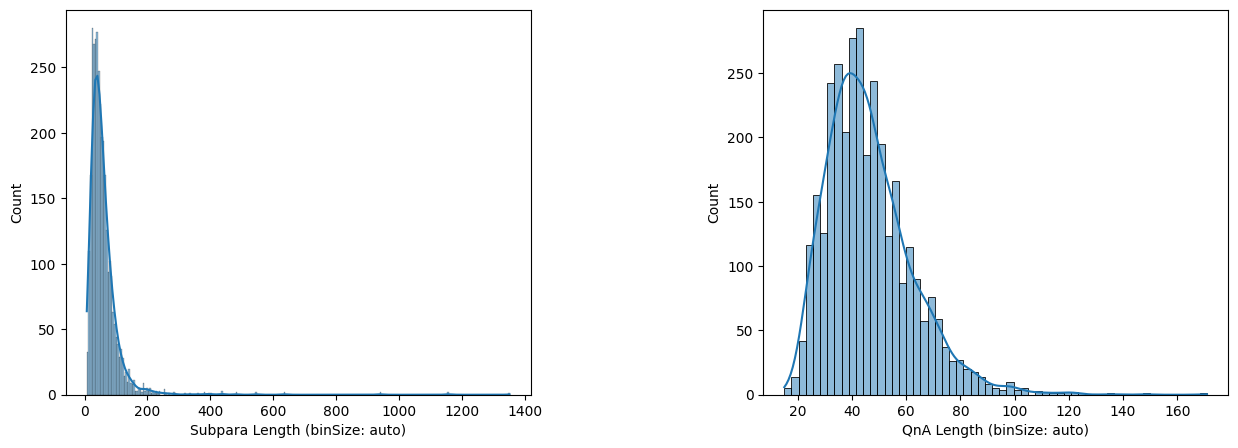

In [ ]:
f, axes = plt.subplots(1,2,figsize=(15,5))
ax = sns.histplot(full_dataset.input_lengths, kde=True, ax=axes[0])
ax.set(xlabel='Subpara Length (binSize: auto)')

ax = sns.histplot(full_dataset.output_lengths, kde=True, ax=axes[1])
ax.set(xlabel='QnA Length (binSize: auto)')
f.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
print("Input dimension: ", full_dataset.input.shape)
print("Output dimension:", full_dataset.output.shape)

Input dimension:  torch.Size([3314, 300])
Output dimension: torch.Size([3314, 180])


In [ ]:
train_data,test_data,val_data=random_split(full_dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42))

In [ ]:
print(f"Train:Test:Val = {len(train_data)}:{len(test_data)}:{len(val_data)}")
i,o = train_data[0]
print("Train Input dim: ", i.shape)
print("Train Output dim:", o.shape)

Train:Test:Val = 2652:331:331
Train Input dim:  torch.Size([300])
Train Output dim: torch.Size([180])


In [ ]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

# Transformer Model
Add decoder

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        position = torch.arange(max_len).unsqueeze(1)
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [ ]:
# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, args):#ntoken: int, d_model: int, nhead: int, d_hid: int,
                #  nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'

        self.emsize = args['emsize']
        self.generator = nn.Linear(args['emsize'], args['ntokens'])
        self.embedding = TokenEmbedding(vocab_size=args['ntokens'], emb_size=args['emsize'])
        self.pos_enc = PositionalEncoding(args['emsize'], dropout=args['dropout'])

        self.transformer = Transformer(d_model=args['emsize'],
                                       nhead=args['nheads'],
                                       num_encoder_layers=args['num_encoder_layers'],
                                       num_decoder_layers=args['num_decoder_layers'],
                                       dim_feedforward=args['dim_feedforward'],
                                       dropout=args['dropout'])


        # self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self,
                src: Tensor,
                tgt: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src_emb, tgt_emb = self.embedding(src), self.embedding(tgt)
        src_pos_emb, tgt_pos_emb = self.pos_enc(src_emb), self.pos_enc(tgt_emb)
        outs = self.transformer(src_pos_emb, tgt_pos_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)

        output = self.generator(outs)
        return output

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.pos_enc(
                            self.embedding(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.pos_enc(
                          self.embedding(tgt)), memory,
                          tgt_mask)

In [ ]:
def generate_square_subsequent_mask(sz, args):
    mask = (torch.triu(torch.ones((sz, sz), device=args['device'])) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt, args):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len, args)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=args['device']).type(torch.bool)

    src_padding_mask = (src == args['pad_idx']).transpose(0, 1)
    tgt_padding_mask = (tgt == args['pad_idx']).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

# Loading and training model

In [ ]:
args['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args['pad_idx'] = full_dataset.vocab['[pad]']
args['ntokens'] = len(full_dataset.vocab) # size of vocab
args['emsize'] = 200                      # embedding dim
args['d_hid'] = 200     # dim of Linear network in nn.TransformerEncoder
args['num_encoder_layers'] = 3     # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
args['num_decoder_layers'] = 3     # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
args['dim_feedforward'] = 512     # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
args['nheads'] = 2       # number of heads in nn.MultiHeadAttention
args['dropout'] = 0.2   # dropout prob

model = TransformerModel(args).to(args['device'])

In [ ]:
import time

criterion = nn.CrossEntropyLoss(ignore_index=args['pad_idx'])
lr = 5.0  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()

    num_batches = len(train_loader)
    for batch_idx, (input_batch, target_batch) in enumerate(train_loader):
        input_batch = input_batch.to(args['device']).T
        target_batch = target_batch.to(args['device']).T

        # print("t1.shape:",target_batch.shape)
        target_batch_inp = target_batch[:-1,:]
        # print("t2.shape:",target_batch_inp.shape)
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(input_batch, target_batch_inp, args)

        logits = model(input_batch, target_batch_inp, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        # print("logits:", logits.shape)
        # print("tgt:", target_batch.shape)
        optimizer.zero_grad()
        tgt_out = target_batch[1:,:]
        # print("tgt_out:", tgt_out.shape)

        # print("logits reshaped:", logits.reshape(-1, logits.shape[-1]).shape)
        # print("tgt_out reshaped:", tgt_out.reshape(-1).shape)
        # raise
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        # if batch_idx % log_interval == 0 and batch_idx > 0:
        #     lr = scheduler.get_last_lr()[0]
        #     ms_per_batch = (time.time() - start_time) * 1000 / log_interval
        #     cur_loss = total_loss / log_interval
        #     ppl = math.exp(cur_loss)
        #     print(f'| epoch {epoch:3d} | {batch_idx:5d}/{num_batches:5d} batches | '
        #           f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
        #           f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
        #     total_loss = 0
        #     start_time = time.time()
    return total_loss / len(train_loader)
def evaluate(model: nn.Module, d_loader) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
      for input_batch, target_batch in d_loader:
            src = input_batch.to(args['device']).T
            tgt = target_batch.to(args['device']).T

            tgt_input = tgt[:-1, :]

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, args)

            logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

            tgt_out = tgt[1:, :]
            loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            total_loss += loss.item()
    return total_loss / len(d_loader)

In [ ]:
len(full_dataset.vocab)

18046

In [ ]:
best_val_loss = float('inf')
epochs = 50

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train_loss = train(model)
        val_loss = evaluate(model, train_loader)
        # val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'train loss {train_loss:5.2f} | valid loss {val_loss:8.2f}')
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_params_path)

        scheduler.step()
    model.load_state_dict(torch.load(best_model_params_path))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 15.03s | train loss  5.96 | valid loss     5.89
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 15.38s | train loss  5.96 | valid loss     5.89
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 15.19s | train loss  5.96 | valid loss     5.88
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 14.94s | train loss  5.95 | valid loss     5.88
----------------------------------------------------------------------

In [ ]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(args['device'])
    src_mask = src_mask.to(args['device'])

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(args['device'])
    for i in range(max_len-1):
        memory = memory.to(args['device'])
        tgt_mask = (generate_square_subsequent_mask(ys.size(0),args)
                    .type(torch.bool)).to(args['device'])
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == full_dataset.vocab['[end]']:
            break
    return ys
itos = full_dataset.vocab.get_itos()
def convertToken2Str(token_list):
  return " ".join(itos[idx] for idx in token_list)

# actual function to translate input sentence into target language
def generate(model: torch.nn.Module, src):
    model.eval()
    src = src[0].unsqueeze(1)
    num_tokens = src.shape[0]
    print(num_tokens)
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=180, start_symbol=full_dataset.vocab['[start]']).flatten()

    return convertToken2Str(list(tgt_tokens.cpu().numpy()))

In [ ]:
test_sample_input,test_sample_output = next(iter(test_loader))

In [ ]:
test_sample_input.shape

torch.Size([128, 300])

In [ ]:
print(generate(model, test_sample_input))

300
[start] what are the study of the study ? [sep] the study of the study of the study of the study of the study of the study of the study of the study of the study , and the study , and the study , and the study , and the what , and the study , and the what , and the what , and the what , and the what , and the what , and the what , and the what , and the study , and the study , and the what , and the study , and the what , and the what , and the study , and the study , and the what , and the study , and the study , and the study , and the study , and the study , and the study , and the what , and the study , and the study , and the study , and the study , and the study , and the study , and the study , and the study


In [ ]:
" ".join([itos[idx] for idx in list(test_sample_input.cpu().numpy())[0]])

'he said i think it has worked well because over the years during their annual review which we were invited to , their report , the ghana health service ( ghs ) indicated that there is a drastic reduction of maternal mortality and many more so i know it has worked . it has also worked because it seems the ladies now feel comfortable attending antenatal than before . [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [

In [ ]:
" ".join([itos[idx] for idx in list(test_sample_output.cpu().numpy())[0]])

"[start] how have the annual reviews conducted by the ghana health service indicated that the fmhcp has been successful ? [sep] the ghana health service ' s annual reviews have indicated that there is a drastic reduction of maternal mortality , and that women now feel more comfortable attending antenatal care than before . [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pa